# Conversion Rate Prediction

This notebook builds a machine learning model to predict whether a user will convert based on browsing session data.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


## Loading Dataset

In [14]:
df = pd.read_csv("conversion_data_train.csv")
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [16]:
df.shape

(284580, 6)

In [39]:
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [36]:
df_sample=df.sample(10000)

The dataset contains more than 280,000 observations.
In order to reduce computation time during the prototyping phase,
a subsample will be used to train the exploratory models.

The final model can be trained on the entire dataset.

## EDA

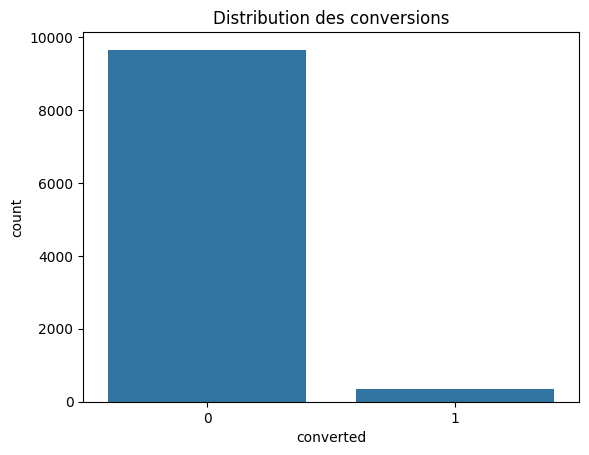

In [38]:
sns.countplot(x=df_sample['converted'])
plt.title("Distribution des conversions")
plt.show()

In [40]:
df_sample['converted'].value_counts(normalize=True)

converted
0    0.9652
1    0.0348
Name: proportion, dtype: float64

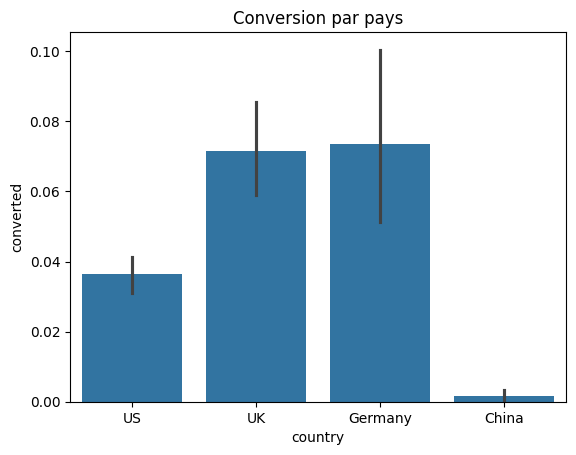

In [41]:
sns.barplot(x='country', y='converted', data=df_sample)
plt.title("Conversion par pays")
plt.show()

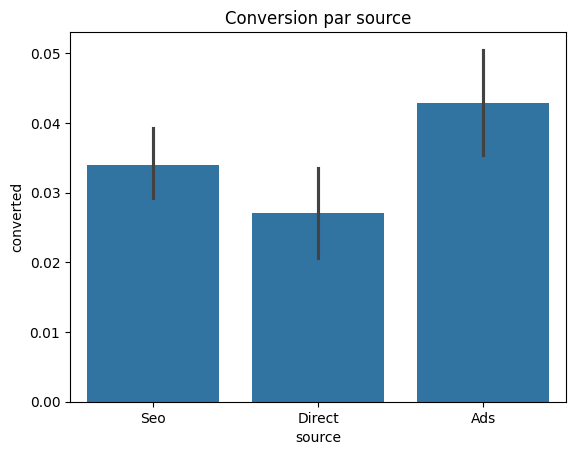

In [42]:
sns.barplot(x='source', y='converted', data=df_sample)
plt.title("Conversion par source")
plt.show()

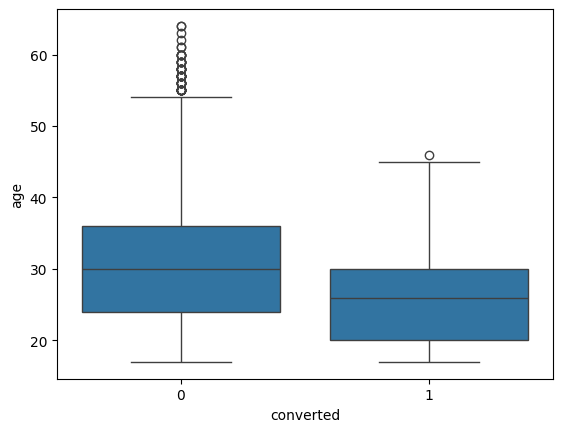

In [43]:
sns.boxplot(x='converted', y='age', data=df_sample)
plt.show()

## Baseline model

In [44]:
features_list = ['total_pages_visited']
target_variable = 'converted'

X = df_sample.loc[:, features_list]
y = df_sample.loc[:, target_variable]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [46]:
numeric_indices = [0]

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices)
    ]
)

In [47]:
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [48]:
baseline_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [51]:
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

print(f"F1-score train : {f1_score(y_train, y_train_pred):.3f}")
print(f"F1-score test :  {f1_score(y_test, y_test_pred):.3f}")

F1-score train : 0.686
F1-score test :  0.748


In [ ]:
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train, y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test, y_test_pred))
print()


Confusion matrix on train set : 
[[7686   36]
 [ 114  164]]

Confusion matrix on test set : 
[[1918   12]
 [  21   49]]



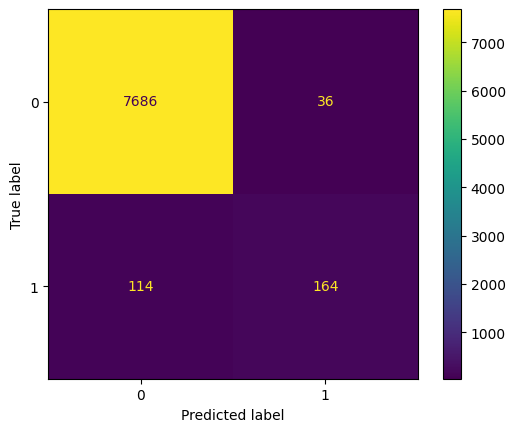

In [53]:
cm = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

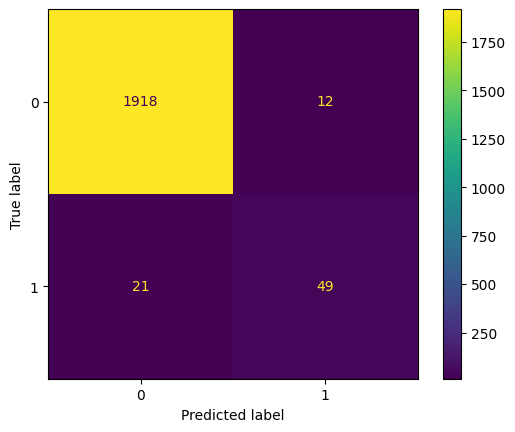

In [52]:
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

#### Interpretation

The confusion matrix shows that the model is able to correctly identify the majority of users who will not subscribe to the newsletter.
It is also capable of detecting some of the users who are likely to convert.
However, some genuinely interested users are not identified by the model, which represents missed conversion opportunities for the company.
The model could therefore be used to target marketing actions, although improvements are needed to reduce the number of false negatives.

## Improving the Model Using All Available Features

The baseline model was trained using only one explanatory variable.
We now aim to improve the model's performance by using all available features in the dataset.

In [57]:
X = df_sample.drop("converted", axis=1)
y = df_sample["converted"]

In [58]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [60]:
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [71]:
pipe_rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

In [72]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5]
}

In [73]:
grid = GridSearchCV(
    pipe_rfc,
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

In [74]:
grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [5, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [75]:
print("Best parameters:", grid.best_params_)

Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}


In [76]:
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

print(f"F1-score train : {f1_score(y_train, y_train_pred):.3f}")
print(f"F1-score test :  {f1_score(y_test, y_test_pred):.3f}")

F1-score train : 0.836
F1-score test :  0.829


## Model Improvement Using All Features

By including all available features in the model (such as country, age, user status, and traffic source), the predictive performance has significantly improved compared to the baseline model trained on a single variable.

A Random Forest classifier was implemented and optimized using GridSearchCV with cross-validation in order to capture potential non-linear relationships within the data.

The optimized model achieved an F1-score of 0.836 on the training set and 0.829 on the test set. The small difference between these scores indicates that the model generalizes well to unseen data and does not suffer from overfitting.

These results suggest that incorporating additional user information allows the model to better understand user behavior and improve the identification of potential newsletter subscribers.

## Final Training on the Full Dataset

The final model is retrained on the entire available training dataset in order to maximize the amount of information available for learning before generating predictions on unseen data.

In [77]:
X_full = df_sample.drop("converted", axis=1)
y_full = df_sample["converted"]

grid.fit(X_full, y_full)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [5, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


## Generating Predictions on the Test Dataset

In [78]:
test_data = pd.read_csv("conversion_data_test.csv")

In [79]:
predictions = grid.predict(test_data)

In [80]:
pd.Series(predictions).value_counts()

0    30748
1      872
Name: count, dtype: int64

In [81]:
pd.Series(predictions).value_counts(normalize=True)

0    0.972423
1    0.027577
Name: proportion, dtype: float64

## Predictions Analysis

The model predicts that 872 users out of 30,748 are likely to subscribe to the newsletter, which represents approximately 2.7% of the total users.

This result appears realistic, as newsletter subscription rates are typically low in real-world scenarios. The model therefore provides plausible predictions regarding user conversion behavior.

In [82]:
submission = pd.DataFrame({
    "converted": predictions
})

submission.to_csv("conversion_data_test_predictions_TEAM-NAME.csv", index=False)

## Business Recommendations

The predictive model developed in this project allows the company to identify users who are more likely to subscribe to the newsletter based on their browsing behavior and profile.

In particular, features such as the number of pages visited, user status (new or returning), traffic source, and country appear to have a significant influence on the probability of conversion.

This information can be leveraged by the marketing team to implement targeted strategies aimed at improving the newsletter subscription rate.

## Actionable Insights

For example, users who visit a higher number of pages may be more engaged and therefore more likely to subscribe. These users could be targeted with personalized pop-ups or subscription prompts during their browsing session.

Similarly, identifying traffic sources associated with higher conversion rates may help optimize marketing campaigns by focusing efforts on the most effective acquisition channels.

New users could also benefit from tailored onboarding experiences or incentives to encourage early subscription.

## Strategic Value

By using this predictive model, the company can move from a generic marketing approach to a more data-driven strategy, enabling more efficient allocation of resources and potentially increasing the overall newsletter conversion rate.

## Conclusion

Overall, this machine learning approach provides valuable insights into user behavior and offers practical opportunities to enhance user engagement and improve conversion performance.